In [ ]:
---
title: "Developing notebook"
format: html
---

In [9]:
import os, sys, re, csv
from pathlib import Path
home = str(Path.home())
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
import numpy as np
import scipy as sp
import pandas as pd
from scipy import optimize as opt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import scipy.odr as odr
import networkx as nx
import seaborn as sns
import utils as ut

Here we read the whole matrix of Ws and try to understand the distributions.

The dimension of the matrix is:


In [2]:
result_dir = home +"/workspace/data/PredPheno/cellbox/results/20230405_cyano_rna_5c08105256c016c79573735ab13502a2"

In [3]:
result_folders = [f for f in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, f))]
result_scores = []
for folder in result_folders:
    # print(folder)
    seed = int(re.findall(r'\d+\.\d+|\d+', folder)[0])
    w_files = [listed for listed in os.listdir(result_dir + "/" + folder) if "best.W" in listed]
    # print(w_files)
    result_scores += [[seed] + [float(num) if '.' in num else int(num) for num in re.findall(r'\d+\.\d+|\d+', file)] for file in w_files]
result_scores = pd.DataFrame(result_scores, columns=["seed", "rep", "score"])

array([[<Axes: title={'center': 'score'}>]], dtype=object)

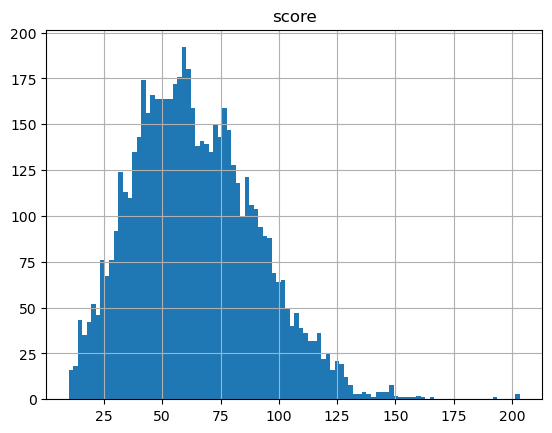

In [4]:
result_scores.hist(column="score", bins=100)

In [25]:
result_scores.sort_values(by="score", ascending=True).head(1000)

,seed,rep,score
629,309,4,9.926870
626,309,3,10.038133
628,309,5,10.069534
627,309,6,10.149461
854,620,4,11.334103
...,...,...,...
4960,891,1,38.265818
2198,96,1,38.282120
2700,118,3,38.288755
1832,603,3,38.301510


This part is to check if the replites are similar to each other in the same run than the ones from different runs

In [30]:
pairwise_dist = []
for i in range(6000):
    for j in range(i+1, 6000):
        a_seed = '{:0>{}}'.format(str(result_scores.iloc[i, 0]), 3)
        b_seed = '{:0>{}}'.format(str(result_scores.iloc[j, 0]), 3)
        a_rep = str(result_scores.iloc[i, 1])
        b_rep = str(result_scores.iloc[j, 1])
        a_file = [listed for listed in os.listdir(result_dir + "/seed_" + a_seed) if a_rep + "_best.W" in listed][0]
        b_file = [listed for listed in os.listdir(result_dir + "/seed_" + b_seed) if b_rep + "_best.W" in listed][0]
        a_df = pd.read_csv(result_dir + "/seed_" + a_seed + '/' + a_file, index_col=0)
        b_df = pd.read_csv(result_dir + "/seed_" + b_seed + '/' + b_file, index_col=0)
        dist = [np.linalg.norm(a_df.to_numpy() - b_df.to_numpy())]
        if a_seed == b_seed:
            dist += ["Same run"]
        else:
            dist += ["Different run"]
        pairwise_dist += [dist]
pairwise_dist = pd.DataFrame(pairwise_dist, columns=["dist", "run"])

In [ ]:
a_df

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,...,2.310000e+02,232.000000,233.000000,234.000000,2.350000e+02,236.000000,237.000000,238.000000,239.000000,240.000000
1,H6G84_RS01130,0.000000,-8.165607e-07,1.498929e-06,5.155198e-08,1.286289e-06,1.023354e-06,-7.327789e-07,-8.794304e-07,1.695374e-06,...,-4.221628e-06,-0.005111,-0.002024,-0.002442,4.017302e-06,0.000004,0.000001,-0.001475,0.000004,0.000005
2,H6G84_RS04855,-0.000468,-0.000000e+00,3.812503e-02,-9.371778e-05,3.192987e-02,-2.048858e-04,-6.691681e-04,8.069598e-04,5.959206e-03,...,1.174209e-02,-0.026200,-0.010695,-0.017788,-4.039873e-03,-0.007272,0.015254,0.000146,-0.003594,0.008892
3,H6G84_RS00870,-0.000008,6.094303e-03,0.000000e+00,-5.022666e-06,6.504445e-03,-9.977775e-06,-9.719786e-06,1.322989e-05,9.420239e-04,...,1.464931e-02,-0.002019,0.000996,-0.002395,-4.454137e-02,-0.023455,0.000132,0.000002,-0.062944,0.019908
4,H6G84_RS08385,0.000005,-4.831151e-09,-3.328435e-07,0.000000e+00,4.628359e-07,6.833135e-08,1.706381e-06,5.599247e-07,-4.523852e-08,...,-1.401594e-08,-0.000102,-0.000023,-0.000010,5.825229e-07,0.000004,0.000010,0.000001,-0.000006,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,P_pAM2991-galP,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,...,0.000000e+00,0.000000,-0.000000,0.000000,0.000000e+00,0.000000,-0.000000,0.000000,-0.000000,-0.000000
238,P_pilB::Tn5,0.000000,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,...,-0.000000e+00,0.000000,-0.000000,-0.000000,0.000000e+00,0.000000,-0.000000,0.000000,-0.000000,0.000000
239,P_BG-11,0.000000,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,...,-0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.000000,-0.000000,-0.000000,0.000000
240,P_CM,0.000000,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000,0.000000,0.000000,0.000000e+00,-0.000000,0.000000,0.000000,-0.000000,-0.000000


Now let's check the training loss of the best case

In [7]:
single_result = result_dir + "/seed_309"
evals = pd.read_csv(single_result + '/record_eval.csv', index_col=False)
reps_info = evals[evals["epoch"] == -1].copy()
reps_info

,epoch,iter,train_loss,valid_loss,train_mse,valid_mse,test_mse,time_elapsed
4452,-1,None,None,15.213312149047852,None,12.060959815979004,None,0.544789
4453,-1,None,None,None,None,None,90.7645492553711,0.575253
4747,-1,None,None,12.302494049072266,None,11.637838363647461,None,0.042501
4748,-1,None,None,None,None,None,90.27490234375,0.068754
5679,-1,None,None,9.710819244384766,None,9.603802680969238,None,0.047083
5680,-1,None,None,None,None,None,88.04105377197266,0.075067
5909,-1,None,None,9.582138061523438,None,9.54543685913086,None,0.043134
5910,-1,None,None,None,None,None,88.02452850341797,0.073435
8723,-1,None,None,9.667705535888672,None,9.546300888061523,None,1.146407
8724,-1,None,None,None,None,None,87.7486572265625,1.285423


In [21]:
epoch_idx = [(reps_info.index.to_list()[2*(i)+1] + 1) for i in range(6)]
epoch_nums = [epoch_idx[i] - epoch_idx[i-1] if i > 0 else epoch_idx[i] for i in range(len(epoch_idx))]
evals["Replication"] = ut.flatten([[j+1] * n for j, n in enumerate(epoch_nums)])

In [22]:
evals

,epoch,iter,train_loss,valid_loss,train_mse,valid_mse,test_mse,time_elapsed,Replication
0,0,0,376.005859375,320.91949462890625,69.29823303222656,22.199968338012695,None,5.553386,1
1,0,1,435.92755126953125,311.8403625488281,137.2080535888672,19.5178165435791,None,0.072990,1
2,0,2,404.2559814453125,309.1499328613281,111.9334487915039,22.125133514404297,None,0.070087,1
3,0,3,361.38299560546875,303.7342529296875,74.35818481445312,21.152240753173828,None,0.068128,1
4,0,4,373.77496337890625,302.520751953125,91.19296264648438,23.68679428100586,None,0.059688,1
...,...,...,...,...,...,...,...,...,...
9491,153,766,86.29322814941406,9.829644203186035,86.15917205810547,9.695585250854492,None,0.393553,6
9492,153,767,66.00064086914062,11.071438789367676,65.86658477783203,10.937397003173828,None,0.399714,6
9493,153,768,43.79759979248047,10.929181098937988,43.66355895996094,10.795134544372559,None,0.388433,6
9494,-1,None,None,9.662282943725586,None,9.528236389160156,None,2.621492,6


In [ ]:
#| label: fig_training_validation_loss
#| fig-cap: "Plots of training and validation loss"


In [ ]:
matrix_w = pd.read_csv(w_file, header=None)
print(matrix_w.shape)
# print(matrix_w.abs().max().max())
# print(matrix_w.abs().min().min())

In [ ]:
df = matrix_w.copy()
df[df.abs() == 0] = np.nan
print(df.abs().max().max())
print(df.abs().min().min())
print(df.max().max())
print(df.min().min())


Ploting the histogram of all values:


In [ ]:
#| label: fig_w_dist
#| fig-cap: "Distribution of Ws"
matrix_w.stack().plot.hist(bins=100);


Now if we set arbitrary thresholds say abs(w) > 0.1


In [ ]:
#| label: fig_w_dist_0.1
#| fig-cap: "Distribution of Ws"
df = matrix_w.copy()
df[df.abs() < 0.1] = np.nan
df.stack().plot.hist(bins=100);
# df[df>0].stack().plot.hist(bins=100);
# df[df<0].stack().plot.hist(bins=100);


Now if we increaset to 0.5


In [ ]:
#| label: fig_w_dist_0.5
#| fig-cap: "Distribution of Ws"
df = matrix_w.copy()
df[df.abs() < 0.5] = np.nan
df.stack().plot.hist(bins=100);
# df[df>0].stack().plot.hist(bins=100);
# df[df<0].stack().plot.hist(bins=100);


It seems the histogram can not reflect what are the values distritbute, here is what we can do:
1) transform all the values to absolute 
2) replace zeros with nan
3) log10 transform all the values
4) replot the histogram


In [ ]:
#| label: fig_w_log10_dist
#| fig-cap: "Distribution of log10(abs(Ws))"
matrix_wlog10 = np.log10(matrix_w.abs().replace(0, np.nan))
matrix_wlog10.stack().plot.hist(bins=100);


Now based on the distribution of log10(abs(Ws)), we can fairly say that $10^{-3}$ is a good candidate for the cut-off. We take all values whose absotlute is smaller than $10^{-3}$ will be $0$ and considered as no interactions.

Now if we plot them with their actual values after filtering:


In [ ]:
matrix_w_temp = matrix_wlog10.copy().replace(0, np.nan)
matrix_w_temp[matrix_w_temp <= -3] = np.nan
matrix_w_temp += 3.2
matrix_w_temp[matrix_w < 0] = - matrix_w_temp[matrix_w < 0]
matrix_w_temp.stack().plot.hist(bins=100).set_xticks([-3.2, -2.2, -1.2 , -0.2, 0.2, 1.2, 2.2, 3.2], ["-1", "-0.1", "-0.01", "-0.001", "0.001", "0.01", "0.1", "1"], rotation=60);


When transform back to linear scale it looks like:


In [ ]:
matrix_w_new_log = matrix_wlog10.copy().replace(0, np.nan)
matrix_w_new_log[matrix_w_new_log <= -3] = np.nan
matrix_w_new_log += 3.0
matrix_w_new_log[matrix_w < 0] = - matrix_w_new_log[matrix_w < 0]

matrix_w_new = matrix_wlog10.copy().replace(0, np.nan)
matrix_w_new[matrix_w_new <= -3] = np.nan
matrix_w_new = 10 ** matrix_w_new
matrix_w_new[matrix_w < 0] = - matrix_w_new[matrix_w < 0]
matrix_w_new.stack().plot.hist(bins=100);


Now we construct the network to see the structure of model:

First, we plot the heatmaps of the interactions: 


In [ ]:
#| label: fig_w_log10_heatmap
#| fig-cap: "Heatmap of Ws"
sns.heatmap(matrix_w_new_log, cmap="coolwarm", center=0, cbar_kws={'ticks': [-3, -2, -1, 0, 1, 2, 3]}).collections[0].colorbar.set_ticklabels([-1, -0.1, -0.01, 0, 0.01, 0.1, 1]);


If we color them using linear scale values:


In [ ]:
#| label: fig_w_heatmap
#| fig-cap: "Heatmap of Ws in linear scale"
sns.heatmap(matrix_w_new, cmap="coolwarm", center=0);


And if we set the threshold as 0.01


In [ ]:
#| label: fig_w_log10_heatmap_0.01
#| fig-cap: "Heatmap of Ws"
df = matrix_w_new_log.copy()
df[df.abs() < 1] = np.nan
sns.heatmap(df, cmap="coolwarm", center=0, cbar_kws={'ticks': [-3, -2, -1, 0, 1, 2, 3]}).collections[0].colorbar.set_ticklabels([-1, -0.1, -0.01, 0, 0.01, 0.1, 1]);


In [ ]:
#| label: fig_w_heatmap_0.01
#| fig-cap: "Heatmap of Ws in linear scale"
df = matrix_w_new.copy()
df[df.abs() < 0.01] = np.nan
sns.heatmap(df, cmap="coolwarm", center=0);


What about 0.1?


In [ ]:
#| label: fig_w_log10_heatmap_0.1
#| fig-cap: "Heatmap of Ws"
df = matrix_w_new_log.copy()
df[df.abs() < 2] = np.nan
sns.heatmap(df, cmap="coolwarm", center=0, cbar_kws={'ticks': [-3, -2, -1, 0, 1, 2, 3]}).collections[0].colorbar.set_ticklabels([-1, -0.1, -0.01, 0, 0.01, 0.1, 1]);


In [ ]:
#| label: fig_w_heatmap_0.1
#| fig-cap: "Heatmap of Ws in linear scale"
df = matrix_w_new.copy()
df[df.abs() < 0.1] = np.nan
sns.heatmap(df, cmap="coolwarm", center=0);


In [ ]:
print(matrix_w_new.abs().max().max())
print(matrix_w_new.abs().min().min())


The heatmap is showing the perturbations and phenotypes are connected with molecular signatures. And it is why there are missing values between the perturbations and phenotypes.

Next, we construct network to see what subnetworks are generated. 


In [ ]:
df = matrix_w.copy()
df[df.abs() < 0.001] = 0
# df[df <= -0.001] = -1
# df[df >= 0.001] = 1
G = nx.from_numpy_array(df.to_numpy(), create_using=nx.DiGraph())
df001 = matrix_w.copy()
df001[df001.abs() < 0.01] = 0
# df001[df001 <= -0.01] = -1
# df001[df001 >= 0.01] = 1
G001 = nx.from_numpy_array(df001.to_numpy(), create_using=nx.DiGraph())
df01 = matrix_w.copy()
df01[df01.abs() < 0.1] = 0
# df01[df01 <= -0.1] = -1
# df01[df01 >= 0.1] = 1
G01 = nx.from_numpy_array(df01.to_numpy(), create_using=nx.DiGraph())
# df05 = matrix_w.copy()
# df05[df05.abs() < 0.5] = 0
# df05[df05.abs() <= -0.5] = -1
# df05[df05.abs() >= 0.5] = 1
# G05 = nx.from_numpy_array(df05.to_numpy(), create_using=nx.DiGraph())
# df09 = matrix_w.copy()
# df09[df09.abs() < 0.9] = 0
# df09[df09.abs() <= -0.9] = -1
# df09[df09.abs() >= 0.9] = 1
# G09 = nx.from_numpy_array(df09.to_numpy(), create_using=nx.DiGraph())
# df1 = matrix_w.copy()
# df1[df1.abs() < 1] = 0
# df1[df1.abs() <= -1] = -1
# df1[df1.abs() >= 1] = 1
# G1 = nx.from_numpy_array(df1.to_numpy(), create_using=nx.DiGraph())


Calculate the connected components with differently filtered networks.


In [ ]:
G_comp = [len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
G01_comp = [len(c) for c in sorted(nx.strongly_connected_components(G01), key=len, reverse=True)]
G001_comp = [len(c) for c in sorted(nx.strongly_connected_components(G001), key=len, reverse=True)]
# G05_comp = [len(c) for c in sorted(nx.strongly_connected_components(G05), key=len, reverse=True)]
# G09_comp = [len(c) for c in sorted(nx.strongly_connected_components(G09), key=len, reverse=True)]
# G1_comp = [len(c) for c in sorted(nx.strongly_connected_components(G1), key=len, reverse=True)]
print("Network with 1e-3 threshold has", len(G_comp), " strongly connected components. And their sizes are:")
print(G_comp)
print("Network with 1e-2 threshold has", len(G001_comp), " strongly connected components. And their sizes are:")
print(G001_comp)
print("Network with 1e-1 threshold has", len(G01_comp), " strongly connected components. And their sizes are:")
print(G01_comp)
# print("Network with 5e-1 threshold has", len(G05_comp), " strongly connected components. And their sizes are:")
# print(G05_comp)
# print("Network with 9e-1 threshold has", len(G09_comp), " strongly connected components. And their sizes are:")
# print(G09_comp)
# print("Network with 1 threshold has", len(G1_comp), " strongly connected components. And their sizes are:")
# print(G1_comp)


##### Visualization of these graphs

TODO: Drop all zeros


In [ ]:
nodes_num = 157


Networks of 0.001


In [ ]:
df = matrix_w.copy()
df[df.abs() < 0.001] = 0
G = nx.from_numpy_array(df.iloc[:nodes_num, :nodes_num].to_numpy(), create_using=nx.DiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G)


Networks of 0.01


In [ ]:
df = matrix_w.copy()
df[df.abs() < 0.01] = 0
G = nx.from_numpy_array(df.iloc[:nodes_num, :nodes_num].to_numpy(), create_using=nx.DiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G)


Networks of 0.1


In [ ]:
df = matrix_w.copy()
df[df.abs() < 0.1] = 0
G = nx.from_numpy_array(df.iloc[:nodes_num, :nodes_num].to_numpy(), create_using=nx.DiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G)


Now what is more important is whether cellbox has a good enough model. Need to check the loss function.


In [ ]:
df
